In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib
import os

In [2]:
data_dir = './dataset/Cap_RuiShi'

In [3]:
data_root = pathlib.Path(data_dir)

In [4]:
for item in data_root.iterdir():
    print(item)

dataset\Cap_RuiShi\19Holes
dataset\Cap_RuiShi\7Holes


In [5]:
all_image_path = list(data_root.glob('*/*'))

In [6]:
len(all_image_path)

336

In [7]:
all_image_path = [str(path) for path in all_image_path]

In [8]:
import random

In [9]:
random.shuffle(all_image_path)

In [10]:
all_image_path[0: 12]

['dataset\\Cap_RuiShi\\19Holes\\55.jpeg',
 'dataset\\Cap_RuiShi\\19Holes\\48.jpeg',
 'dataset\\Cap_RuiShi\\7Holes\\_14.jpeg',
 'dataset\\Cap_RuiShi\\7Holes\\_5.jpeg',
 'dataset\\Cap_RuiShi\\7Holes\\_54.jpeg',
 'dataset\\Cap_RuiShi\\7Holes\\42.jpeg',
 'dataset\\Cap_RuiShi\\7Holes\\_40.jpeg',
 'dataset\\Cap_RuiShi\\19Holes\\_36.jpeg',
 'dataset\\Cap_RuiShi\\19Holes\\10.jpeg',
 'dataset\\Cap_RuiShi\\19Holes\\36.jpeg',
 'dataset\\Cap_RuiShi\\7Holes\\14.jpeg',
 'dataset\\Cap_RuiShi\\19Holes\\136.jpeg']

In [11]:
image_count = len(all_image_path)

In [12]:
label_names = sorted(item.name for item in data_root.glob('*/'))

In [13]:
label_names

['19Holes', '7Holes']

In [14]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))

In [15]:
label_to_index

{'19Holes': 0, '7Holes': 1}

In [16]:
all_image_label = [label_to_index[pathlib.Path(p).parent.name] for p in all_image_path]

In [17]:
all_image_label[0:12]

[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0]

In [18]:
import IPython.display as display

In [19]:
index_to_label = dict((v, k) for k, v in label_to_index.items())

In [20]:
index_to_label

{0: '19Holes', 1: '7Holes'}

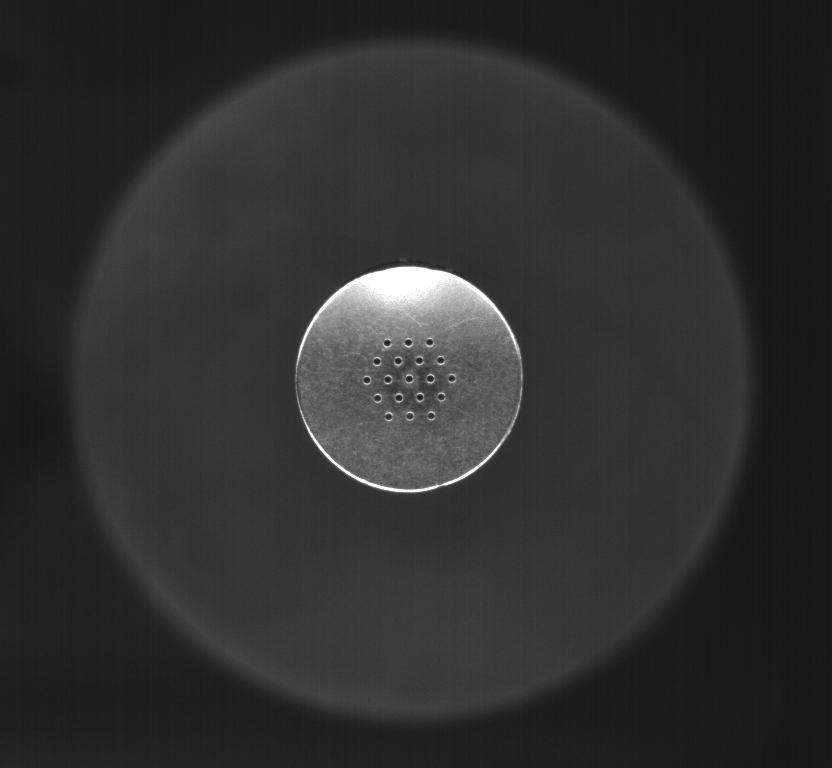

19Holes



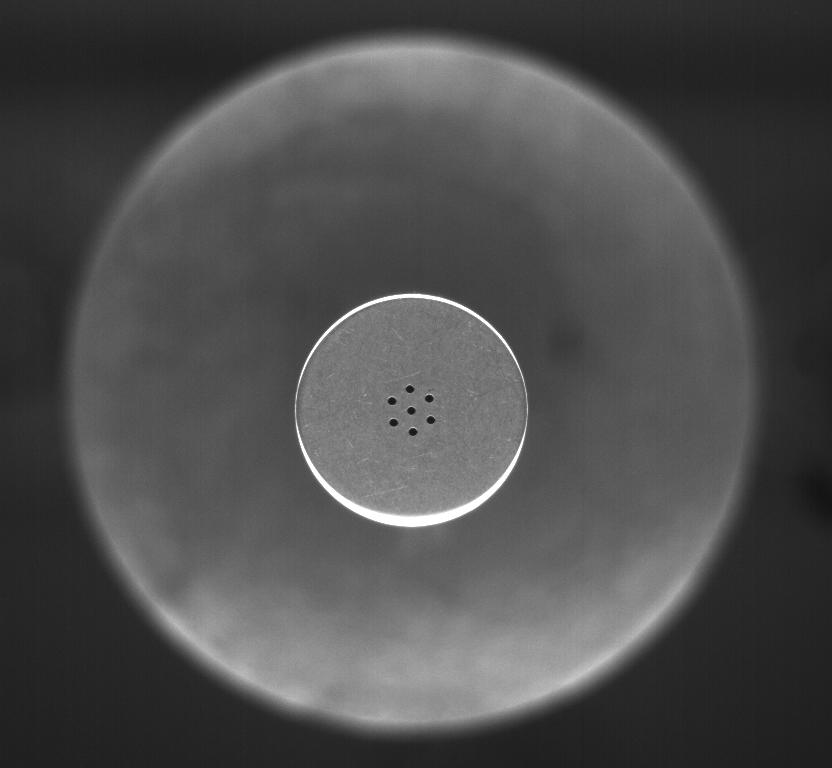

7Holes



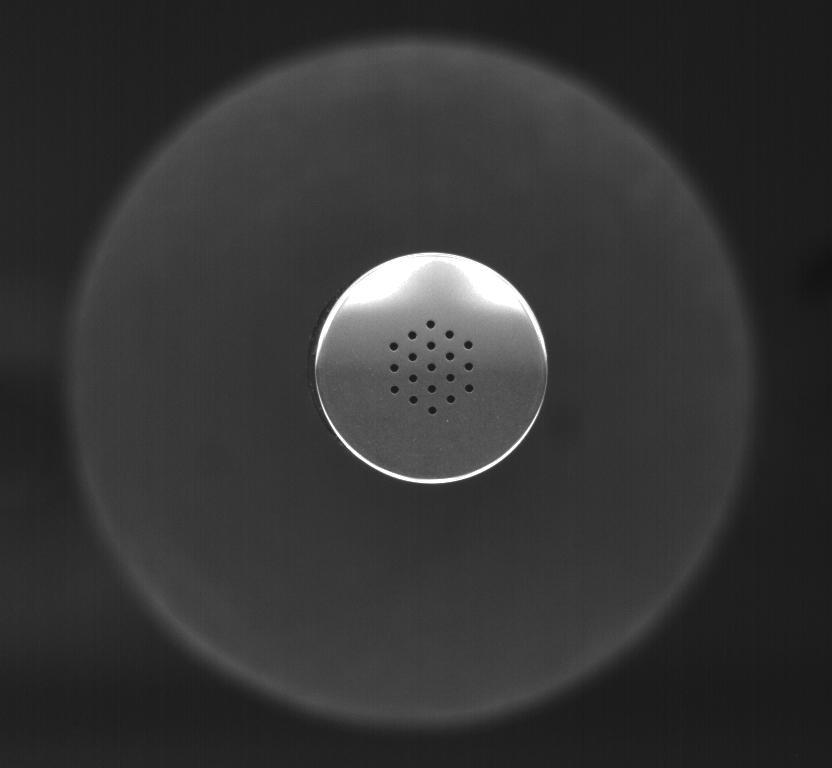

19Holes



In [21]:
for n in range(3):
    image_index = random.choice(range(len(all_image_path)))
    display.display(display.Image(all_image_path[image_index]))
    print(index_to_label[all_image_label[image_index]])
    print()

In [22]:
#test
img_path = all_image_path[0]
img_raw = tf.io.read_file(img_path)
img_tensor = tf.image.decode_jpeg(img_raw, channels = 3)

In [23]:
img_tensor.shape

TensorShape([768, 832, 3])

In [24]:
def load_preprosess_image(img_path):
    img_raw = tf.io.read_file(img_path)
    img_tensor = tf.image.decode_jpeg(img_raw, channels = 3)
    img_tensor = tf.image.resize(img_tensor, [768, 832])
    
    img_tensor = tf.image.random_brightness(img_tensor, 0.3)
    img_tensor = tf.image.random_contrast(img_tensor, 1, 2)
    img_tensor = tf.image.random_hue(img_tensor, 0.2)
    img_tensor = tf.image.random_flip_left_right(img_tensor)
    img_tensor = tf.image.random_flip_left_right(img_tensor)
    
    img_tensor = tf.cast(img_tensor, tf.float32)
    img = img_tensor / 255
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


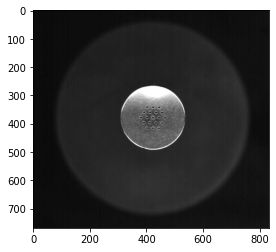

In [25]:
image_temp_path = all_image_path[100]
plt.imshow(load_preprosess_image(image_temp_path))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


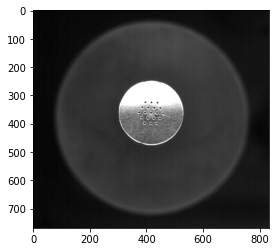

In [26]:
plt.imshow(load_preprosess_image(all_image_path[110]))

In [27]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_path)

In [28]:
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [29]:
image_dataset = path_ds.map(load_preprosess_image)

In [30]:
image_dataset

<MapDataset shapes: (768, 832, 3), types: tf.float32>

In [31]:
label_dataset = tf.data.Dataset.from_tensor_slices(all_image_label)

In [32]:
for label in label_dataset.take(10):
    print(label.numpy())

0
0
1
1
1
1
1
0
0
0


In [33]:
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

In [34]:
dataset

<ZipDataset shapes: ((768, 832, 3), ()), types: (tf.float32, tf.int32)>

In [35]:
test_count = int(image_count * 0.3)
train_count = image_count - test_count

In [36]:
test_count, train_count

(100, 236)

In [37]:
train_dataset = dataset.skip(test_count)
test_dataset = dataset.take(test_count)

In [38]:
BATCH_SIZE = 32

In [39]:
train_dataset = train_dataset.repeat().shuffle(buffer_size = train_count).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# 使用预训练网路Xception模型

In [40]:
covn_base = tf.keras.applications.xception.Xception(weights = 'imagenet',
                                                    include_top = False,
                                                    input_shape = (768, 832, 3),
                                                    pooling = 'avg')

In [41]:
covn_base.trainable = False

In [42]:
covn_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 832, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 383, 415, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 383, 415, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 383, 415, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [43]:
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [45]:
initial_epochs = 10

In [46]:
'''
model = tf.keras.Sequential()  #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape = (768, 832, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(2048, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(2048, (3, 3), activation = 'relu'))

model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(4096, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(4096, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(8192, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(8192, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(16384, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(16384, (3, 3), activation = 'relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2048, activation = 'relu'))
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
'''

"\nmodel = tf.keras.Sequential()  #顺序模型\nmodel.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape = (768, 832, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.MaxPooling2D())\nmodel.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.MaxPooling2D())\nmodel.add(tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.MaxPooling2D())\nmodel.add(tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.MaxPooling2D())\nmodel.add(tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'))\nmodel.add(tf.keras.layers.MaxPooling2D())\nmodel.add(tf.keras.layers

In [47]:
'''
model = tf.keras.Sequential()  #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape = (768, 832, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(256, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(512, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(1024, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(2048, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(2048, (3, 3), padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
'''

"\nmodel = tf.keras.Sequential()  #顺序模型\nmodel.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape = (768, 832, 3), padding = 'same'))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Activation('relu'))\n\nmodel.add(tf.keras.layers.Conv2D(64, (3, 3), padding = 'same'))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Activation('relu'))\n\nmodel.add(tf.keras.layers.MaxPooling2D())\nmodel.add(tf.keras.layers.Conv2D(128, (3, 3), padding = 'same'))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Activation('relu'))\n\nmodel.add(tf.keras.layers.Conv2D(128, (3, 3), padding = 'same'))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Activation('relu'))\n\nmodel.add(tf.keras.layers.MaxPooling2D())\nmodel.add(tf.keras.layers.Conv2D(256, (3, 3), padding = 'same'))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Activation('relu'))\n\nmodel.add(tf.keras.layers.

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [50]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
    #lr = 0.0005),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

In [51]:
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = test_count//BATCH_SIZE

In [52]:
history = model.fit(train_dataset, 
                    epochs= initial_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_dataset,
                    validation_steps = validation_steps)

Train for 7 steps, validate for 3 steps
Epoch 1/10
7/7 [==============================] - 26s 4s/step - loss: 0.7347 - acc: 0.4688 - val_loss: 0.6994 - val_acc: 0.3542
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 0.5810 - acc: 0.7277 - val_loss: 0.6785 - val_acc: 0.4479
Epoch 3/10
7/7 [==============================] - 12s 2s/step - loss: 0.4482 - acc: 0.9286 - val_loss: 0.6032 - val_acc: 0.6458
Epoch 4/10
7/7 [==============================] - 12s 2s/step - loss: 0.3405 - acc: 0.9062 - val_loss: 0.6781 - val_acc: 0.4792
Epoch 5/10
7/7 [==============================] - 12s 2s/step - loss: 0.3221 - acc: 0.9420 - val_loss: 0.5495 - val_acc: 0.7500
Epoch 6/10
7/7 [==============================] - 12s 2s/step - loss: 0.2384 - acc: 0.9509 - val_loss: 0.5681 - val_acc: 0.7188
Epoch 7/10
7/7 [==============================] - 12s 2s/step - loss: 0.1814 - acc: 0.9688 - val_loss: 0.5146 - val_acc: 0.7604
Epoch 8/10
7/7 [==============================] - 12s 2s/step - 

ValueError: x, y, and format string must not be None

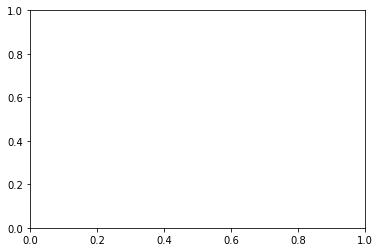

In [108]:
plt.plot(history.epoch, history.history.get('acc'), label = 'acc')
plt.plot(history.epoch, history.history.get('val_acc'), label = 'val_acc')
plt.legend()

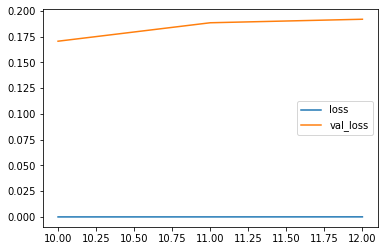

In [109]:
plt.plot(history.epoch, history.history.get('loss'), label = 'loss')
plt.plot(history.epoch, history.history.get('val_loss'), label = 'val_loss')
plt.legend()

# 微调

In [110]:
len(covn_base.layers)

133

In [111]:
fine_tune_at = -33

In [112]:
covn_base.trainable = True

In [113]:
for layer in covn_base.layers[:fine_tune_at]:
    layer.trainable = False

In [114]:
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 0.0005/10),
             metrics = ['accuracy'])

In [131]:
fine_tune_epochs = 2
total_epochs = initial_epochs + fine_tune_epochs

history = model.fit(
                    train_dataset,
                    steps_per_epoch = train_count // BATCH_SIZE,
                    epochs = total_epochs,
                    initial_epoch = initial_epochs,
                    validation_data = test_dataset,
                    validation_steps = test_count // BATCH_SIZE)

Train for 7 steps, validate for 3 steps
Epoch 11/12
7/7 [==============================] - 23s 3s/step - loss: 4.7848e-06 - accuracy: 1.0000 - val_loss: 0.1655 - val_accuracy: 1.0000
Epoch 12/12
7/7 [==============================] - 16s 2s/step - loss: 7.8892e-06 - accuracy: 1.0000 - val_loss: 0.1348 - val_accuracy: 1.0000


In [132]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

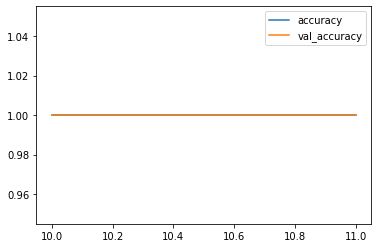

In [133]:
plt.plot(history.epoch, history.history.get('accuracy'), label = 'accuracy')
plt.plot(history.epoch, history.history.get('val_accuracy'), label = 'val_accuracy')
plt.legend()

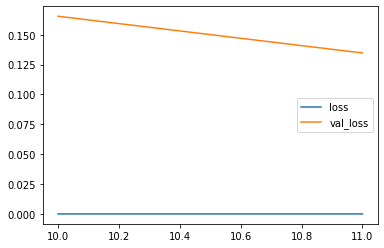

In [134]:
plt.plot(history.epoch, history.history.get('loss'), label = 'loss')
plt.plot(history.epoch, history.history.get('val_loss'), label = 'val_loss')
plt.legend()

# 验证模型

In [135]:
test_imgs, test_labels = next(iter(test_dataset))

In [136]:
test_labels[:5].numpy()

array([0, 0, 1, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


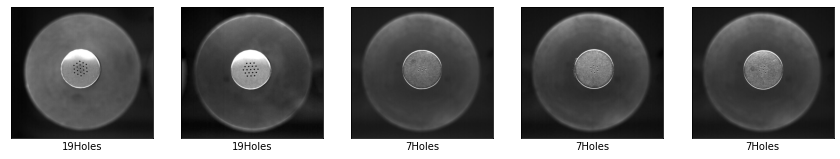

In [137]:
plt.figure(figsize=(30,30))
for test_num in range(5):
    plt.subplot(10,10,test_num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_imgs[test_num], cmap=plt.cm.binary)
    plt.xlabel(index_to_label[test_labels[test_num].numpy()])
plt.show()

In [138]:
prediction = model.predict(test_dataset)

In [183]:
predict_label = {}
print('预测结果：')
for test_num in range(5):
    if prediction[test_num]>=0.5:
        predict_label[test_num] = 1
    else:
        predict_label[test_num] = 0    
    pre_name = str(index_to_label[predict_label[test_num]])    
    print(predict_label[test_num],',',pre_name)

预测结果：
0 , 19Holes
0 , 19Holes
1 , 7Holes
1 , 7Holes
1 , 7Holes


In [140]:
#model.save_weights('E:\TF_project\MyProject\My_model\_7Holes&9Holes_Classify')

In [141]:
model.evaluate(test_dataset, verbose = 0)

[0.1400284469127655, 1.0]

In [173]:
#取一张本地图片来验证测试
my_image = load_preprosess_image(r'E:\Cap_RuiShi\219.jpeg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


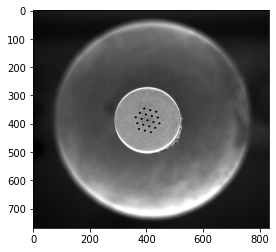

In [174]:
plt.imshow(my_image)

In [150]:
my_image.shape

TensorShape([768, 832, 3])

In [151]:
my_image = np.expand_dims(my_image, 0)
my_image.shape

(1, 768, 832, 3)

In [162]:
pre = model.predict(my_image)

In [167]:
pre

array([[0.3118218]], dtype=float32)

In [185]:
print('预测结果：')
if pre>0.5:
    pre = 1
else:
    pre = 0    
pre_name = str(index_to_label[pre])
print('标识:', pre , ',' , pre_name)


预测结果：
标识: 0 , 19Holes


In [207]:
xlabel = 'Origin_Label:0 , 19Holes  Predict:',pre,pre_name

In [214]:
my_image = np.squeeze(my_image)
my_image.shape

(768, 832, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, "('Origin_Label:0 , 19Holes  Predict:', 0, '19Holes')")

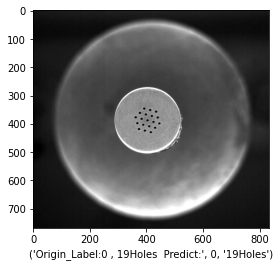

In [215]:
plt.imshow(my_image)
plt.xlabel(xlabel = xlabel)